In [1]:
import time

# work with directories
import os 
from pathlib import Path 

# datetime
import datetime as dt

# work with data
import numpy as np
import pandas as pd
# import pandas_datareader.data as web # not needed for this code

# visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# create bag of word vector
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# gensim
import pyLDAvis.gensim_models
from gensim.models import LdaMulticore, TfidfModel
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import gensim._matutils
import multiprocessing
import IPython

import warnings
warnings.filterwarnings("ignore")


### 1. Load data

Here we load the data for each company from the 'Consumer Staples' sector. The files were generated in `1_Data_Preprocessing.ipynb`

In [2]:
chd_df = pd.read_csv("../data/CHD.csv")
print(chd_df.shape)
chd_df.head(5)

(70, 7)


,text,patent_id,ticker,numpat_total,issue_date,sector,clean_corpus
0,FIELD OF THE INVENTION\n\nThe present inventio...,7665418,CHD,395,2/23/2010,Consumer Staples,field invent present invent relat absorb compo...
1,FIELD OF THE INVENTION\n\nThe present inventio...,7723629,CHD,395,5/25/2010,Consumer Staples,field invent present invent relat field toothb...
2,RELATED APPLICATIONS AND PATENTS\n\nThe presen...,7763454,CHD,395,7/27/2010,Consumer Staples,relat applic patent present invent relat u.s. ...
3,FIELD OF THE INVENTION\n\nThe present inventio...,7772578,CHD,395,8/10/2010,Consumer Staples,field invent present invent relat diagnost tes...
4,FIELD OF THE INVENTION\n\nThe invention relate...,7776618,CHD,395,8/17/2010,Consumer Staples,field invent invent relat diagnost assay analy...


In [3]:
cl_df = pd.read_csv("../data/CL.csv")
print(cl_df.shape)
cl_df.head(5)

(335, 7)


,text,patent_id,ticker,numpat_total,issue_date,sector,clean_corpus
0,This invention is directed to a dispensing con...,7690531,CL,3401,4/6/2010,Consumer Staples,invent direct dispens contain enhanc appear pa...
1,BACKGROUND OF THE INVENTION\n\nHard surface cl...,7700536,CL,3401,4/20/2010,Consumer Staples,background invent hard surfac cleaner usual wa...
2,FIELD OF THE INVENTION\n\nThe present inventio...,7703163,CL,3401,4/27/2010,Consumer Staples,field invent present invent relat toothbrush m...
3,BACKGROUND OF THE INVENTION\n\nThe efficacy of...,7704531,CL,3401,4/27/2010,Consumer Staples,background invent efficaci antiperspir salt in...
4,BACKGROUND OF THE INVENTION\n\nThe present inv...,7707677,CL,3401,5/4/2010,Consumer Staples,background invent present invent direct manual...


In [5]:
cpb_df = pd.read_csv("../data/CPB.csv")
print(cpb_df.shape)
cpb_df.head(5)

(4, 7)


,text,patent_id,ticker,numpat_total,issue_date,sector,clean_corpus
0,FIELD OF THE INVENTION\n\nThe present inventio...,8463423,CPB,137,6/11/2013,Consumer Staples,field invent present invent relat general syst...
1,FIELD OF THE INVENTION\n\nThe present inventio...,9066627,CPB,137,6/30/2015,Consumer Staples,field invent present invent relat instant food...
2,BACKGROUND OF THE INVENTION\n\n1. Field of Inv...,9193510,CPB,137,11/24/2015,Consumer Staples,background invent 1. field invent invent relat...
3,FIELD OF THE INVENTION\n\nThe present inventio...,9873603,CPB,137,1/23/2018,Consumer Staples,field invent present invent relat apparatus fi...


In [6]:
hsy_df = pd.read_csv("../data/HSY.csv")
print(hsy_df.shape)
hsy_df.head(5)

(18, 7)


,text,patent_id,ticker,numpat_total,issue_date,sector,clean_corpus
0,FIELD OF THE INVENTION AND INTRODUCTION\n\nThe...,7641930,HSY,27,1/5/2010,Consumer Staples,field invent introduct invent relat novel meth...
1,FIELD OF THE INVENTION\n\nThis invention gener...,7721908,HSY,27,5/25/2010,Consumer Staples,field invent invent general relat hand-held co...
2,FIELD OF THE INVENTION\n\nThis invention relat...,7829127,HSY,27,11/9/2010,Consumer Staples,field invent invent relat general calcium fort...
3,FIELD OF THE INVENTION AND INTRODUCTION\n\nThe...,7919135,HSY,27,4/5/2011,Consumer Staples,field invent introduct invent relat new bevera...
4,FIELD OF THE INVENTION\n\nThe invention relate...,8088431,HSY,27,1/3/2012,Consumer Staples,field invent invent relat food product ingredi...


In [13]:
sector_df = pd.concat([chd_df, cl_df], axis=0)
sector_df = pd.concat([sector_df, cpb_df], axis=0)
sector_df = pd.concat([sector_df, hsy_df], axis=0)
sector_df.shape

(427, 7)

### 2. Corpus data

Here we create the dataframes including only the patent_id and clean_corpus for each company.

In [14]:
# Helper functions

def sort_by_date(df):
    df['issue_date'] = pd.to_datetime(df['issue_date'])
    df = df.sort_values('issue_date').reset_index(drop=True)
    return df

def create_corpus(input_df):
    '''
    This function creates the corpus and remove rows with no patent data information
    
    '''
    df = input_df.set_index('patent_id')['clean_corpus']
    df.dropna(axis=0, inplace=True)
    return df

In [15]:
sector_df = sort_by_date(sector_df)
sector_df_corpus = create_corpus(sector_df)
sector_df_corpus[:5]

patent_id
7641930    field invent introduct invent relat novel meth...
7665418    field invent present invent relat absorb compo...
7690531    invent direct dispens contain enhanc appear pa...
7700536    background invent hard surfac cleaner usual wa...
7703163    field invent present invent relat toothbrush m...
Name: clean_corpus, dtype: object

### 3. LDA models

In [16]:
# Helper functions

def tfidf_corpus(corpus):
    '''
    This function preprocesses a given corpus creating a dictionary, generating a Bag-of-Words representation, and
    applying TF-IDF transformation.
    
    '''
    gensim_corpus = [doc.split() for doc in corpus.to_list()]
    dictionary = Dictionary(gensim_corpus)
    ldacorpus = [dictionary.doc2bow(doc) for doc in gensim_corpus]
    tfidfmodel = TfidfModel(ldacorpus)
    tfidfmodel_corpus = tfidfmodel[ldacorpus]
    return gensim_corpus, dictionary, ldacorpus, tfidfmodel, tfidfmodel_corpus

def lda_model(corpus,num_topics):
    '''
    This function creates the LDA model for a given corpus and numer of topics.
    
    '''

    tfidf_corpus_outputs = tfidf_corpus(corpus)
    
    lda_gensim = LdaMulticore(tfidf_corpus_outputs[4], 
                          id2word=tfidf_corpus_outputs[1],
                          num_topics=num_topics,
                          workers=min(4, multiprocessing.cpu_count()-1), # number of cores
                          passes=10, # training passes
                          chunksize=200, # no. of documents in each training chuck
                         )
    return lda_gensim


#### 3.1. Optimal number of topics

To obtain the optimal number of topics for each company, we use the coherence score. Firstly, we train LDA models with different numbers of topics (5-20) for each company and compute the coherence values for each of them. Then, we identify the number of topics where the coherence value is highest or plateaus and define this number of topics as the optimal one.

In [17]:
def optimal_topics(corpus):
    # initialize list to save coherence values and lda model
    coherence_values = []
    lda_models = []

    tfidf_corpus_outputs = tfidf_corpus(corpus)

    # for each value of n
    for n in range(5, 21):

        # train the lda model with n topics
        model = LdaMulticore(tfidf_corpus_outputs[4], 
                            id2word=tfidf_corpus_outputs[1],
                            num_topics=n,
                            workers=min(8, multiprocessing.cpu_count()-1), # number of cores
                            passes=10, # training passes
                            chunksize=200, # no. of documents in each training chuck
                            )
        # add the model to the corresponding initialized list
        lda_models.append(model)
        
        # create coherence model with the above trained lda model
        coherencemodel = CoherenceModel(model=model, texts=tfidf_corpus_outputs[0], dictionary=tfidf_corpus_outputs[1], 
                                        coherence='c_v')
        
        # add the value for n and the coherence to the corresponding initialized list
        coherence_val = coherencemodel.get_coherence()
        print(n, coherence_val)
        coherence_values.append( (n, coherence_val) )
    plt.style.use('ggplot')
    plt.plot(*zip(*coherence_values))
    plt.title('Coherence Values for LDA models with Different Number of Topics\n')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence')
    plt.show()

5 0.4838745280286763
6 0.5369880445696301
7 0.5840888682143218
8 0.46883053116974055
9 0.5255524073870435
10 0.5617800804465392
11 0.5233404006064446
12 0.5199348937760256
13 0.5106820216620436
14 0.4830513310672222
15 0.5388737943619303
16 0.526987266962418
17 0.5181292842828603
18 0.4835450622482167
19 0.518099010519618
20 0.5407663985015214


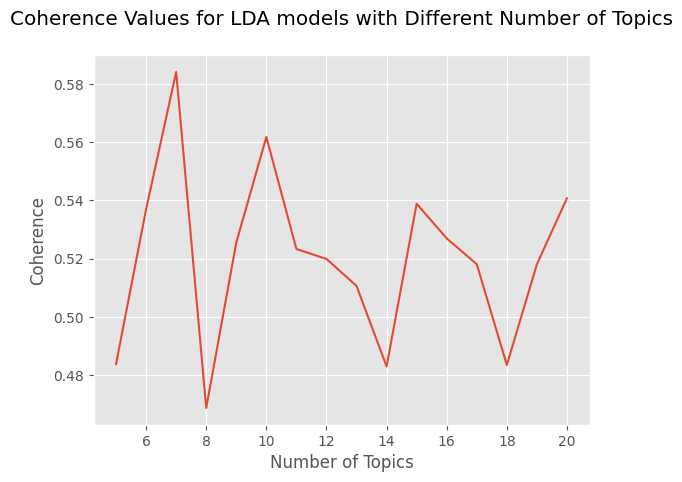

In [18]:
# CHD optimal number of topics

optimal_topics(sector_df_corpus)

Optimal number of topics for the sector: 7

#### 3.2. LDA model for the sector

After identifying the optimal number of topics, we create the LDA topic model for the sector.


In [19]:
# Model

sector_lda = lda_model(sector_df_corpus,7)

In [22]:
# Visualization

sector_tfidf_corpus = tfidf_corpus(sector_df_corpus)

pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim_models.prepare(sector_lda, sector_tfidf_corpus[2], sector_tfidf_corpus[1])

pyLDAvis.save_html(LDAvis_prepared, 'LDAvis_tfidf_sector' + str(7) +'.html')


In [23]:
IPython.display.HTML(filename= 'LDAvis_tfidf_sector' + str(7) +'.html')

### 4. Within-sector novelty/similarity 

To obtain a patent specific measure of novelty we:

a. Obtained the theta parameters (topics weights) for each patent.

b. Calculated the distance between a patent and the previous ones using the theta parameters and cosine similarity.

c. Created three measures by averaging the distance of one patent with the 5, 10 and 20 previous patents. 

In [24]:
# Get the theta parameters for each patent

def theta_param(corpus, model):
    theta_array = []
    tfidf_corpus_outputs = tfidf_corpus(corpus)

    for document in tfidf_corpus_outputs[4]:
        doc_topics = model.get_document_topics(document, minimum_probability=0.0)
        topic_weights = [(topic_id, weight) for topic_id, weight in doc_topics]
        theta_array.append(topic_weights)
    
    return theta_array



In [34]:
def similarity_measure(theta_array):
    '''
    This function calculates the cosine similarity between each document and the previous 5, 10 and 20 documents, 
    using the topics' weights of each patent.
    '''
    # Initialize an empty list to store the results
    result_data = []

    # Iterate over all the documents
    for document_index in range(len(theta_array)):
        previous_documents = [i for i in range(document_index)]

        similarities = []

        for prev_index in previous_documents:
            similarity = gensim.matutils.cossim(theta_array[document_index], theta_array[prev_index])
            similarities.append(similarity)

        avg_similarity_5 = np.mean(similarities[:5])
        avg_similarity_10 = np.mean(similarities[:10])
        avg_similarity_20 = np.mean(similarities[:20])

        # Append the results to the list
        result_data.append({'avg_similarity_5': avg_similarity_5,
                            'avg_similarity_10': avg_similarity_10,
                            'avg_similarity_20': avg_similarity_20})

    # Create the DataFrame from the list of dictionaries
    result_df = pd.DataFrame(result_data)

    return result_df

sector_similarity = similarity_measure(sector_theta_array)


In [35]:
sector_theta_array = theta_param(sector_df_corpus, sector_lda)
sector_similarity = similarity_measure(sector_theta_array)


In [36]:
sector_similarity

,avg_similarity_5,avg_similarity_10,avg_similarity_20
0,NaN,NaN,NaN
1,0.412091,0.412091,0.412091
2,0.434697,0.434697,0.434697
3,0.679079,0.679079,0.679079
4,0.162964,0.162964,0.162964
...,...,...,...
422,0.347848,0.398999,0.359698
423,0.407407,0.385028,0.326846
424,0.209485,0.206207,0.202582
425,0.258020,0.244301,0.230800


Since we are measuring the distance of a patent with the previous 5, 10 and 20, for the first patent of the period we could not calculate the measurements. Also, all three measures start out the same until it get to the point where there are 10 and 20 prior patents.

### 5. Data merge

In [37]:
# Concatenate original df with new variables

sector_final = pd.concat([sector_df,sector_similarity], axis=1)
sector_final.head(5)

,text,patent_id,ticker,numpat_total,issue_date,sector,clean_corpus,avg_similarity_5,avg_similarity_10,avg_similarity_20
0,FIELD OF THE INVENTION AND INTRODUCTION\n\nThe...,7641930,HSY,27,2010-01-05,Consumer Staples,field invent introduct invent relat novel meth...,NaN,NaN,NaN
1,FIELD OF THE INVENTION\n\nThe present inventio...,7665418,CHD,395,2010-02-23,Consumer Staples,field invent present invent relat absorb compo...,0.412091,0.412091,0.412091
2,This invention is directed to a dispensing con...,7690531,CL,3401,2010-04-06,Consumer Staples,invent direct dispens contain enhanc appear pa...,0.434697,0.434697,0.434697
3,BACKGROUND OF THE INVENTION\n\nHard surface cl...,7700536,CL,3401,2010-04-20,Consumer Staples,background invent hard surfac cleaner usual wa...,0.679079,0.679079,0.679079
4,FIELD OF THE INVENTION\n\nThe present inventio...,7703163,CL,3401,2010-04-27,Consumer Staples,field invent present invent relat toothbrush m...,0.162964,0.162964,0.162964


In [38]:
sector_final = sector_final.sort_values(by='issue_date').reset_index(drop=True)

In [47]:
import glob
import pandas as pd

path = '../data/novelty_sam_arts/'

file_list = glob.glob(path + "novelty*.xlsx")

excl_list = []
 
for file in file_list:
    excl_list.append(pd.read_excel(file))
 
novelty_sam_arts = pd.concat(excl_list, ignore_index=True)

# Display the merged DataFrame
print(novelty_sam_arts)


          patent  year  nw  nb  nt  nwc       nov
0        9694797  2017   0   0   0    0  0.970389
1        9824496  2017   0   0   0    1  0.956407
2        9559087  2017   0   0   0    0  0.961838
3        9570476  2017   0   0   0    3  0.945049
4        9779769  2017   0   2   6   25  0.971345
...          ...   ...  ..  ..  ..  ...       ...
2333082  9348533  2016   0   0   0   12  0.952938
2333083  9264330  2016   0   2   5   39  0.977182
2333084  9487566  2016   0   1   1   54  0.989488
2333085  9368898  2016   0   0   0    1  0.946392
2333086  9295371  2016   0   0   1    6  0.956544

[2333087 rows x 7 columns]


In [48]:
novelty_sam_arts['patent'].duplicated().sum()

0

In [49]:
# Final dataset with sam arts novelties and measures created

all_novelty = pd.merge(sector_final, novelty_sam_arts[['patent','nw', 'nb', 'nt', 'nwc', 'nov']], 
                       how="left", left_on='patent_id', right_on='patent')
all_novelty = all_novelty.drop(columns=['patent'])
all_novelty


,text,patent_id,ticker,numpat_total,issue_date,sector,clean_corpus,avg_similarity_5,avg_similarity_10,avg_similarity_20,nw,nb,nt,nwc,nov
0,FIELD OF THE INVENTION AND INTRODUCTION\n\nThe...,7641930,HSY,27,2010-01-05,Consumer Staples,field invent introduct invent relat novel meth...,NaN,NaN,NaN,0.0,10.0,34.0,390.0,0.988917
1,FIELD OF THE INVENTION\n\nThe present inventio...,7665418,CHD,395,2010-02-23,Consumer Staples,field invent present invent relat absorb compo...,0.412091,0.412091,0.412091,0.0,1.0,0.0,70.0,0.990278
2,This invention is directed to a dispensing con...,7690531,CL,3401,2010-04-06,Consumer Staples,invent direct dispens contain enhanc appear pa...,0.434697,0.434697,0.434697,0.0,1.0,1.0,0.0,0.962962
3,BACKGROUND OF THE INVENTION\n\nHard surface cl...,7700536,CL,3401,2010-04-20,Consumer Staples,background invent hard surfac cleaner usual wa...,0.679079,0.679079,0.679079,0.0,0.0,0.0,3.0,0.983057
4,FIELD OF THE INVENTION\n\nThe present inventio...,7703163,CL,3401,2010-04-27,Consumer Staples,field invent present invent relat toothbrush m...,0.162964,0.162964,0.162964,0.0,0.0,0.0,2.0,0.976839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,FIELD OF THE INVENTION\n\nThis invention is di...,9949916,CHD,395,2018-04-24,Consumer Staples,field invent invent direct non-irrit person lu...,0.347848,0.398999,0.359698,0.0,0.0,0.0,25.0,0.983442
423,FIELD OF THE INVENTION\n\nThe invention relate...,9970923,CHD,395,2018-05-15,Consumer Staples,field invent invent relat diagnost assay analy...,0.407407,0.385028,0.326846,0.0,0.0,0.0,0.0,0.949941
424,BACKGROUND\n\nField of the Invention\n\nThe pr...,10001449,CHD,395,2018-06-19,Consumer Staples,background field invent present invent relat d...,0.209485,0.206207,0.202582,NaN,NaN,NaN,NaN,NaN
425,BACKGROUND OF THE INVENTION\n\nField of the In...,10101342,CHD,395,2018-10-16,Consumer Staples,background invent field invent present invent ...,0.258020,0.244301,0.230800,NaN,NaN,NaN,NaN,NaN


In [50]:
all_novelty.to_csv('../data/all_novelty_within_sector.csv', index=False) # Data to be used for prediction

### 6. Comparing novelty measures Sam Arts paper with our measures

Novelty measures Sam Arts paper:

- nw: new words 
- nb: new bigrams (two consecutive words)
- nt: new trigrams (three consecutive words)
- nwc: new word combinations
- nov: novelty (average cosine similarity between a focal patent and all patents filed in the five years before/after the focal patent)

First, we start by examining the distribution of the similarity measures created by us. It can be observed that for all three measures, the values range between 0 and 1, suggesting that the new patents are not very innovative compared to the previous ones.

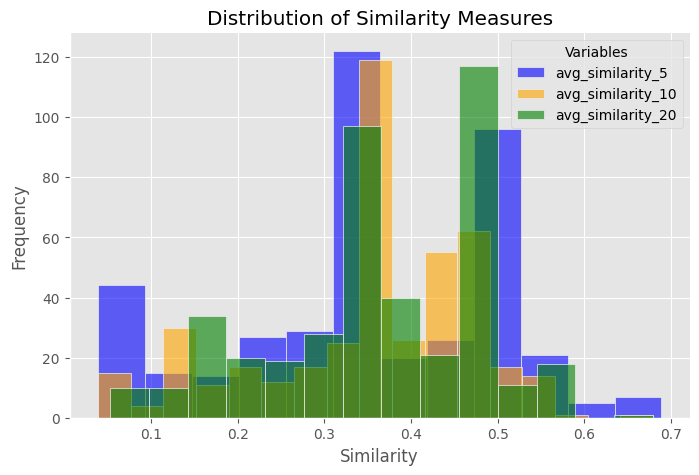

In [51]:
variables = ['avg_similarity_5', 'avg_similarity_10', 'avg_similarity_20']

fig, ax = plt.subplots(figsize=(8, 5))
colors = ['blue', 'orange', 'green']  # Custom colors for each variable

for i, variable in enumerate(variables):
    sns.histplot(data=all_novelty, x=variable, ax=ax, label=variable, color=colors[i], alpha=0.6)

ax.set_xlabel('Similarity')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Similarity Measures')
ax.legend(title='Variables')
sns.despine() 

plt.show()

Secondly, we analyze the correlation between our measures and those from the paper.

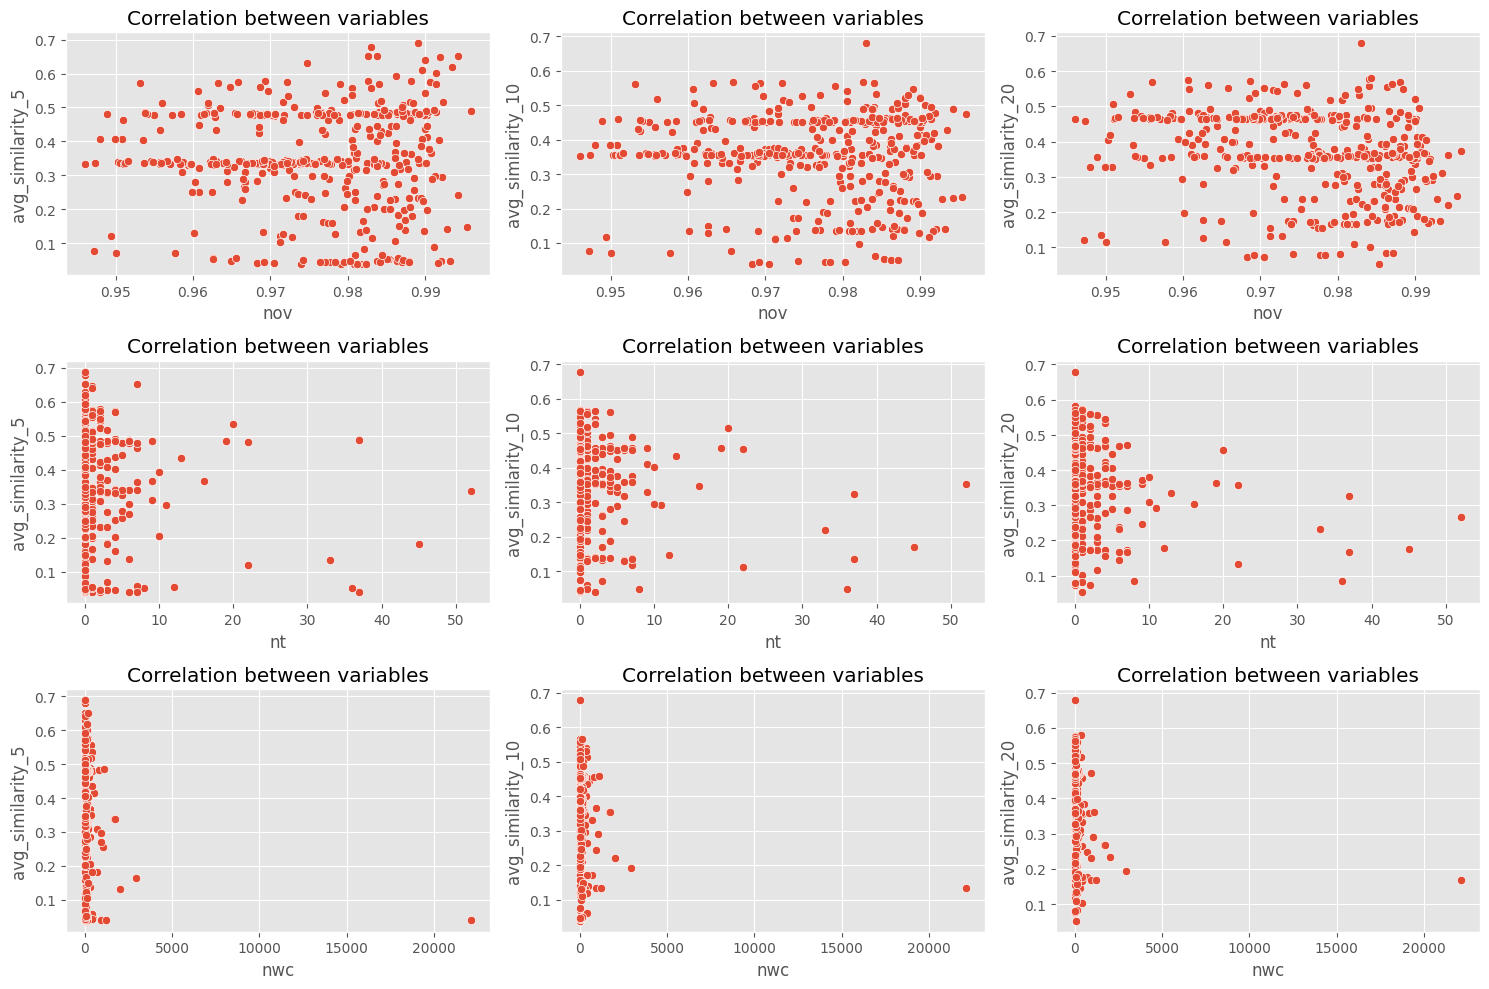

In [52]:
sams_variables = ['nov', 'nt', 'nwc']

fig, axes = plt.subplots(nrows=len(sams_variables), ncols=len(variables), figsize=(15, 10))

for i, sams_variable in enumerate(sams_variables):
    for j, variable in enumerate(variables):
        sns.scatterplot(data=all_novelty, x=sams_variable, y=variable, ax=axes[i, j])
        axes[i, j].set_xlabel(sams_variable)
        axes[i, j].set_ylabel(variable)
        axes[i, j].set_title(f'Correlation between variables')

plt.tight_layout()
plt.show()


In [53]:
correlation_5 = all_novelty['nov'].corr(all_novelty['avg_similarity_5'])
correlation_10 = all_novelty['nov'].corr(all_novelty['avg_similarity_10'])
correlation_20 = all_novelty['nov'].corr(all_novelty['avg_similarity_20'])
print("Correlation novelty - similarity(5 patents): ", correlation_5)
print("Correlation novelty - similarity(10 patents): ", correlation_10)
print("Correlation novelty - similarity(20 patents): ", correlation_20)

Correlation novelty - similarity(5 patents):  -0.01391067103543265
Correlation novelty - similarity(10 patents):  -0.04481564001456592
Correlation novelty - similarity(20 patents):  -0.23119550237135073


 In this case, we can see a low correlation by observing the graphs and a negative correlation observing the calculated coefficients. One possible explanation is that the paper directly analyzes words rather than topics, which can impact novelty since there is a higher probability of incorporating new words rather than new topics. Another reason could be that in our case, the measures compare patents within the same sector. Therefore, it is more likely to find greater distances between patents from different companies and sectors than within the same sector over the time.